# Inbalanced Classes
## In this lab, we are going to explore a case of imbalanced classes. 


Like we disussed in class, when we have noisy data, if we are not careful, we can end up fitting our model to the noise in the data and not the 'signal'-- the factors that actually determine the outcome. This is called overfitting, and results in good results in training, and in bad results when the model is applied to real data. Similarly, we could have a model that is too simplistic to accurately model the signal. This produces a model that doesnt work well (ever). 


### First, download the data from: https://www.kaggle.com/ntnu-testimon/paysim1. Import the dataset and provide some discriptive statistics and plots. What do you think will be the important features in determining the outcome?

In [1]:
# Your code here
import pandas as pd
df=pd.read_csv("df.csv")

### What is the distribution of the outcome? 

In [2]:
# Your response here
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import norm
from scipy.stats import probplot
import matplotlib.pyplot as plt

In [3]:
# Your code here
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
#entiendo que el outcome es saber si es fraude
shapiro(df.isFraud)
# a partir de 5000 no es correcto por lo que hago un probplot

C:\Users\irazu\anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.01416248083114624, pvalue=0.0)

((array([-5.1833966 , -5.01553166, -4.92509216, ...,  4.92509216,
          5.01553166,  5.1833966 ]),
  array([0, 0, 0, ..., 1, 1, 1], dtype=int64)),
 (0.004254145647382276, 0.0012908204481801566, 0.11848394773453047))

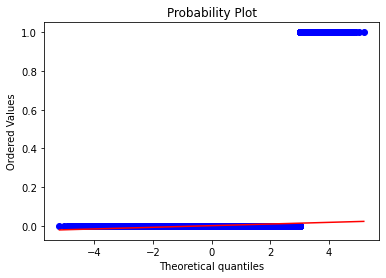

In [24]:
probplot(df.isFraud,plot=plt)

In [6]:
df.isFraud.value_counts()
#Totalmente desvalanceado

0    6354407
1       8213
Name: isFraud, dtype: int64

### Clean the dataset. How are you going to integrate the time variable? Do you think the step (integer) coding in which it is given is appropriate?

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).


In [16]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [8]:
df.isna().sum()
#no hay valores nulos

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [12]:
df.step.value_counts()

19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: step, Length: 743, dtype: int64

In [23]:
from sklearn.preprocessing import KBinsDiscretizer

In [33]:
df.step.value_counts()

19     51352
18     49579
187    49083
235    47491
307    46968
       ...  
432        4
706        4
693        4
112        2
662        2
Name: step, Length: 743, dtype: int64

In [40]:
model=KBinsDiscretizer(n_bins=24,encode="ordinal",strategy='kmeans')

In [43]:
df["n_step"]=model.fit_transform(df[["step"]])

In [58]:
df[["Cash_in_D","Cash_out_D","Debit_D","Payment_D","Transfer_D"]]=pd.get_dummies(df.type)

In [60]:
df.drop(["type","nameOrig","nameDest"],axis=1,inplace=True)

### Run a logisitc regression classifier and evaluate its accuracy.

In [44]:
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [46]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,n_step
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0.0


In [62]:
X=df.drop(["step","isFraud"],axis=1)
y=df.isFraud

In [63]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [64]:
model=LogisticRegression()

In [65]:
model.fit(X_train,y_train)

LogisticRegression()

In [67]:
y_pred=model.predict(X_test)

In [69]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
#Como no esta balanceado le sale muy barato decir que es 0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270920
           1       0.29      0.45      0.36      1604

    accuracy                           1.00   1272524
   macro avg       0.65      0.73      0.68   1272524
weighted avg       1.00      1.00      1.00   1272524



In [70]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
#Oversampling

In [83]:
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

In [84]:
X_train_Over,X_test_Over,y_train_Over,y_test_Over=train_test_split(X_res,y_res,test_size=0.2)

In [73]:
model=LogisticRegression()

In [74]:
model.fit(X_train_Over,y_train_Over)

LogisticRegression()

In [75]:
y_pred=model.predict(X_test_Over)

In [76]:
print(classification_report(y_test_Over, y_pred_Over))
#Ha mejorado bastante

              precision    recall  f1-score   support

           0       0.97      0.66      0.79   1270206
           1       0.74      0.98      0.85   1271557

    accuracy                           0.82   2541763
   macro avg       0.86      0.82      0.82   2541763
weighted avg       0.86      0.82      0.82   2541763



In [ ]:
#Undersampling

In [85]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [86]:
X_train_Under,X_test_Under,y_train_Under,y_test_Under=train_test_split(X_res,y_res,test_size=0.2)

In [79]:
model=LogisticRegression()

In [80]:
model.fit(X_train_Under,y_train_Under)

LogisticRegression()

In [81]:
y_pred=model.predict(X_test_Under)

In [82]:
print(classification_report(y_test_Under, y_pred_Under))
#Con Unversampling es el que mejores resultados hemos tenido

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      1663
           1       0.83      0.98      0.90      1623

    accuracy                           0.89      3286
   macro avg       0.91      0.90      0.89      3286
weighted avg       0.91      0.89      0.89      3286



### Now pick a model of your choice and evaluate its accuracy.

In [87]:
# Your code here
from sklearn.ensemble import RandomForestClassifier

In [88]:
model=RandomForestClassifier()

In [89]:
model.fit(X_train_Under,y_train_Under)

RandomForestClassifier()

In [93]:
y_pred=model.predict(X_test_Under)

In [94]:
print(classification_report(y_test_Under,y_pred))
#Es casi perfecto!

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1633
           1       0.99      1.00      0.99      1653

    accuracy                           0.99      3286
   macro avg       0.99      0.99      0.99      3286
weighted avg       0.99      0.99      0.99      3286



### Which model worked better and how do you know?

In [98]:
# Your response here
#El randomforestclassifier que tiene mejores resultados